In [1]:
print("Hello")
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

Hello
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.5.4.60
    Uninstalling opencv-contrib-python-4.5.4.60:
      Successfully uninstalled opencv-contrib-python-4.5.4.60
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - \ done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=449d2a8231996e4142ded58d1956e0a41dbfff0367d860b7e67bb18900a7fb18
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=08fa89729ddc234618997e7c06edc35233a16fcd614

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)


torch.cuda.is_available()

True

In [3]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')
        
        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [4]:
X = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*'))
y = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*'))

In [5]:
len(y)

2841

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

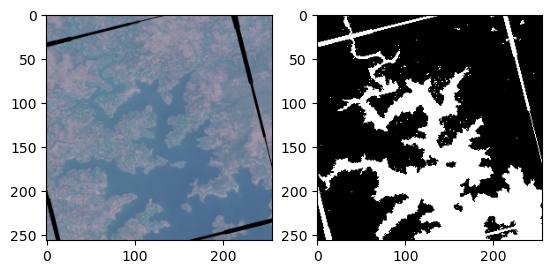

In [8]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [9]:
DEVICE='cuda'

EPOCHS=45
BATCH_SIZE=32
LR=0.001

ratio=0.5 #Various ratios could perform better for visualization
sample_num=18

ENCODER='resnet50'
WEIGHTS='imagenet'

In [10]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

In [11]:
!pip install segmentation-models-pytorch
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def createDeepLabv3(output_channels=1):
    model_deep = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True
    )
    model_deep.classifier = DeepLabHead(2048, output_channels)
    return model_deep

In [13]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

#         self.arc=smp.Unet(
#             encoder_name=ENCODER,
#             encoder_weights=WEIGHTS,
#             in_channels=3,
#             classes=1,
#             activation=None
#         )
    
        self.arc = createDeepLabv3()
    
    def forward(self, images, masks=None):
        logits = self.arc(images)['out']  # Forward pass through the model

        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1, loss2

        return logits


In [14]:
model=SegmentationModel()
model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:00<00:00, 257MB/s]


SegmentationModel(
  (arc): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [15]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    total_loss = 0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [16]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
            
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [17]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
print("device", DEVICE)
#torch.optim.Adam(model.parameters(),lr=LR)

device cuda


In [18]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf
EPOCHS=10
for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

  0%|          | 0/80 [00:07<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 15.90 GiB total capacity; 14.76 GiB already allocated; 67.75 MiB free; 14.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
num=11
ratio=0.5

model.load_state_dict(torch.load('./best_model.pt'))

image,mask=next(iter(valid_loader))
image=image[num]
mask=mask[num]
logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))